In [75]:
import pandas as pd
import json
from pathlib import Path
import re
import sys
sys.path.insert(0, '/home/sagemaker-user/compliance')
from compliance_utils import print_color

FOLDER_HOME: Path = Path('/home/sagemaker-user')
FOLDER_JUDGED_SCENARIOS: Path = FOLDER_HOME / 'data/judged_scenarios/'
FOLDER_JUDGED_SCENARIOS_CSV: Path = FOLDER_JUDGED_SCENARIOS / 'csv/'

In [76]:
def parse_filename(filename):
    parts = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '').split('-')
    complexity = parts[0]
    model = '-'.join(parts[3:-1])
    temp = parts[-1].replace('temp', '')
    
    print(f"Model: {model}")
    print(f"Temp: {temp}")
    print(f"Scenario Complexity: {complexity}")

In [98]:
def analyze_scenarios_in_json_files(folder_path):
    folder = Path(folder_path)
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
                
            print_color(f"\n\n{json_file.name}", 'cyan')
            parse_filename(json_file.name)
            print_color(f"Total={len(scenarios)}", 'blue')
            print("=" * 80)
            
            # Confusion matrix counters
            tp = fp = tn = fn = 0
            
            for scenario in scenarios:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant and judged_compliant:
                    tp += 1
                elif not is_compliant and judged_compliant:
                    fp += 1
                elif not is_compliant and not judged_compliant:
                    tn += 1
                elif is_compliant and not judged_compliant:
                    fn += 1
            
            
            print("Confusion Matrix:")
            print("                Predicted")
            print("Actual      Compliant  Non-Compliant")
            print("Compliant      " + f"\033[92m{tp:4d}\033[0m" + "       " + f"\033[95m{fn:4d}\033[0m")
            print("Non-Compliant  " + f"\033[95m{fp:4d}\033[0m" + "       " + f"\033[92m{tn:4d}\033[0m")

            print(f"% False Positive: {(fp/len(scenarios)):.1%}       % False Negative: {(fn/len(scenarios)):.1%}")

            print("=" * 80)
            
        except Exception as e:
            print_color(f"{json_file.name}: Error - {e}", 'red')


In [78]:
def json_to_csv(json_file: Path, csv_file_path: Path):
    """Convert JSON file to CSV"""
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Handle both formats: {"scenarios": [...]} or [...]
    scenarios = data.get('scenarios', data) if isinstance(data, dict) else data
    
    df = pd.DataFrame(scenarios)
    df.to_csv(csv_file_path, index=False)
    print(f"Converted {json_file_path} to {csv_file_path}")
    
    return csv_file_path


In [79]:
def concatenate_csv_files(input_path: Path, output_file_path: Path):
    """
    Concatenate all CSV files in a directory into one CSV file
    Usage: concatenate_csv_files(Path("/path/to/csv/files"), Path("/path/to/combined_output.csv"))
    """
    csv_files = list(input_path.glob("*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {input_path}")
        return
    
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dfs.append(df)
        print(f"Added {csv_file.name} ({len(df)} rows)")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv(output_file_path, index=False)
    
    print(f"Concatenated {len(csv_files)} files into {output_file_path} ({len(combined_df)} total rows)")
    return output_file_path


In [81]:
import pandas as pd
import json
from pathlib import Path
import re
from collections import defaultdict

def extract_model_from_filename(filename):
    """Extract model name from filename"""
    match = re.search(r'batch-scenarios-(\d+)-policies-each-(.+)-temp(\d+\.\d+)\.json', filename)
    if match:
        model = match.group(2).replace('_', ' ')
        if model.startswith('200-'):
            model = model[4:]
        return model
    return None

def extract_complexity_from_filename(filename):
    """Extract scenario complexity (number of policies) from filename"""
    match = re.search(r'scenarios-(\d+)-policies-each', filename)
    return int(match.group(1)) if match else None

def extract_temperature_from_filename(filename):
    """Extract temperature from filename"""
    match = re.search(r'temp(\d+\.\d+)\.json', filename)
    return float(match.group(1)) if match else None

def load_scenario_data(folder_path):
    """Load all scenario data grouped by complexity"""
    folder = Path(folder_path)
    data_by_complexity = defaultdict(lambda: defaultdict(dict))
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
            
            complexity = extract_complexity_from_filename(json_file.name)
            model = extract_model_from_filename(json_file.name)
            temperature = extract_temperature_from_filename(json_file.name)
            
            if complexity and model and temperature is not None:
                data_by_complexity[complexity][f"{model}_temp{temperature}"] = scenarios
                
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    return data_by_complexity

def create_misjudged_table(scenario_data):
    """Create table of misjudged scenarios for a given complexity"""
    model_temps = list(scenario_data.keys())
    if not model_temps:
        return pd.DataFrame(), 0
    
    # Sort columns by model name, then by temperature
    model_temps.sort(key=lambda x: (x.split('_temp')[0], float(x.split('_temp')[1])))
        
    first_model_temp = model_temps[0]
    scenario_ids = [s['scenario-id'] for s in scenario_data[first_model_temp]]
    
    misjudged_scenarios = []
    
    for scenario_id in scenario_ids:
        misjudged_by = []
        
        for model_temp in model_temps:
            scenario = next((s for s in scenario_data[model_temp] if s['scenario-id'] == scenario_id), None)
            if scenario:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant != judged_compliant:
                    misjudged_by.append(model_temp)
        
        if misjudged_by:
            misjudged_scenarios.append((scenario_id, misjudged_by))
    
    if not misjudged_scenarios:
        return pd.DataFrame(), len(scenario_ids)
    
    table_data = []
    for scenario_id, misjudged_model_temps in misjudged_scenarios:
        row = {'scenario-id': scenario_id}
        for model_temp in model_temps:
            row[model_temp] = 'X' if model_temp in misjudged_model_temps else ''
        row['Count'] = len(misjudged_model_temps)
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    
    # Rename columns to include statistics and temperature
    total_scenarios = len(scenario_ids)
    column_order = ['scenario-id']
    
    for model_temp in model_temps:
        model_misjudged = (df[model_temp] == 'X').sum()
        model_percentage = (model_misjudged / total_scenarios) * 100
        
        # Extract model and temperature for header
        model_name = model_temp.split('_temp')[0]
        temp = model_temp.split('_temp')[1]
        
        new_col_name = f"{model_name}<br>{model_misjudged}/{total_scenarios} = {model_percentage:.1f}%<br>temp{temp}"
        df = df.rename(columns={model_temp: new_col_name})
        column_order.append(new_col_name)
    
    column_order.append('Count')
    df = df[column_order]
    
    return df, total_scenarios

# Load data
folder_path = '/home/sagemaker-user/data/judged_scenarios'
data_by_complexity = load_scenario_data(folder_path)

# Generate markdown output
markdown_output = "# LLM Compliance Evaluation - Misjudged Scenarios Analysis\n\n"

for complexity in sorted(data_by_complexity.keys()):
    table, total_scenarios = create_misjudged_table(data_by_complexity[complexity])
    
    markdown_output += f"## Scenario Set: {complexity} Policies Each\n\n"
    
    if table.empty:
        markdown_output += "✅ **No misjudged scenarios found.**\n\n"
    else:
        misjudged_count = len(table)
        percentage = (misjudged_count / total_scenarios) * 100
        markdown_output += f"**Misjudged scenarios:** {misjudged_count}/{total_scenarios} = {percentage:.1f}%\n\n"
        
        # Convert DataFrame to markdown table
        markdown_output += table.to_markdown(index=False) + "\n\n"
        
        # Summary
        count_summary = table['Count'].value_counts().sort_index()
        markdown_output += "### Summary\n\n"
        for count_val, freq in count_summary.items():
            markdown_output += f"- {freq} scenarios misjudged by {count_val} model(s)\n"
        markdown_output += "\n"

print(markdown_output)


Error loading judged_scenarios_batch-scenarios-8-policies-each-claude_opus_4_5-temp0.1.json: Expecting ',' delimiter: line 1 column 458892 (char 458891)
# LLM Compliance Evaluation - Misjudged Scenarios Analysis

## Scenario Set: 4 Policies Each

**Misjudged scenarios:** 75/200 = 37.5%

| scenario-id     | claude 3 7 sonnet<br>23/200 = 11.5%<br>temp0.0   | claude 3 7 sonnet<br>21/200 = 10.5%<br>temp0.1   | claude 4 sonnet<br>26/200 = 13.0%<br>temp0.0   | claude 4 sonnet<br>31/200 = 15.5%<br>temp0.1   | claude opus 4 5<br>18/200 = 9.0%<br>temp0.0   | nova 2 lite<br>27/200 = 13.5%<br>temp0.0   | nova 2 lite<br>23/200 = 11.5%<br>temp0.2   | nova premier<br>23/200 = 11.5%<br>temp0.0   | nova premier<br>26/200 = 13.0%<br>temp0.1   |   Count |
|:----------------|:-------------------------------------------------|:-------------------------------------------------|:-----------------------------------------------|:-----------------------------------------------|:--------------------------------

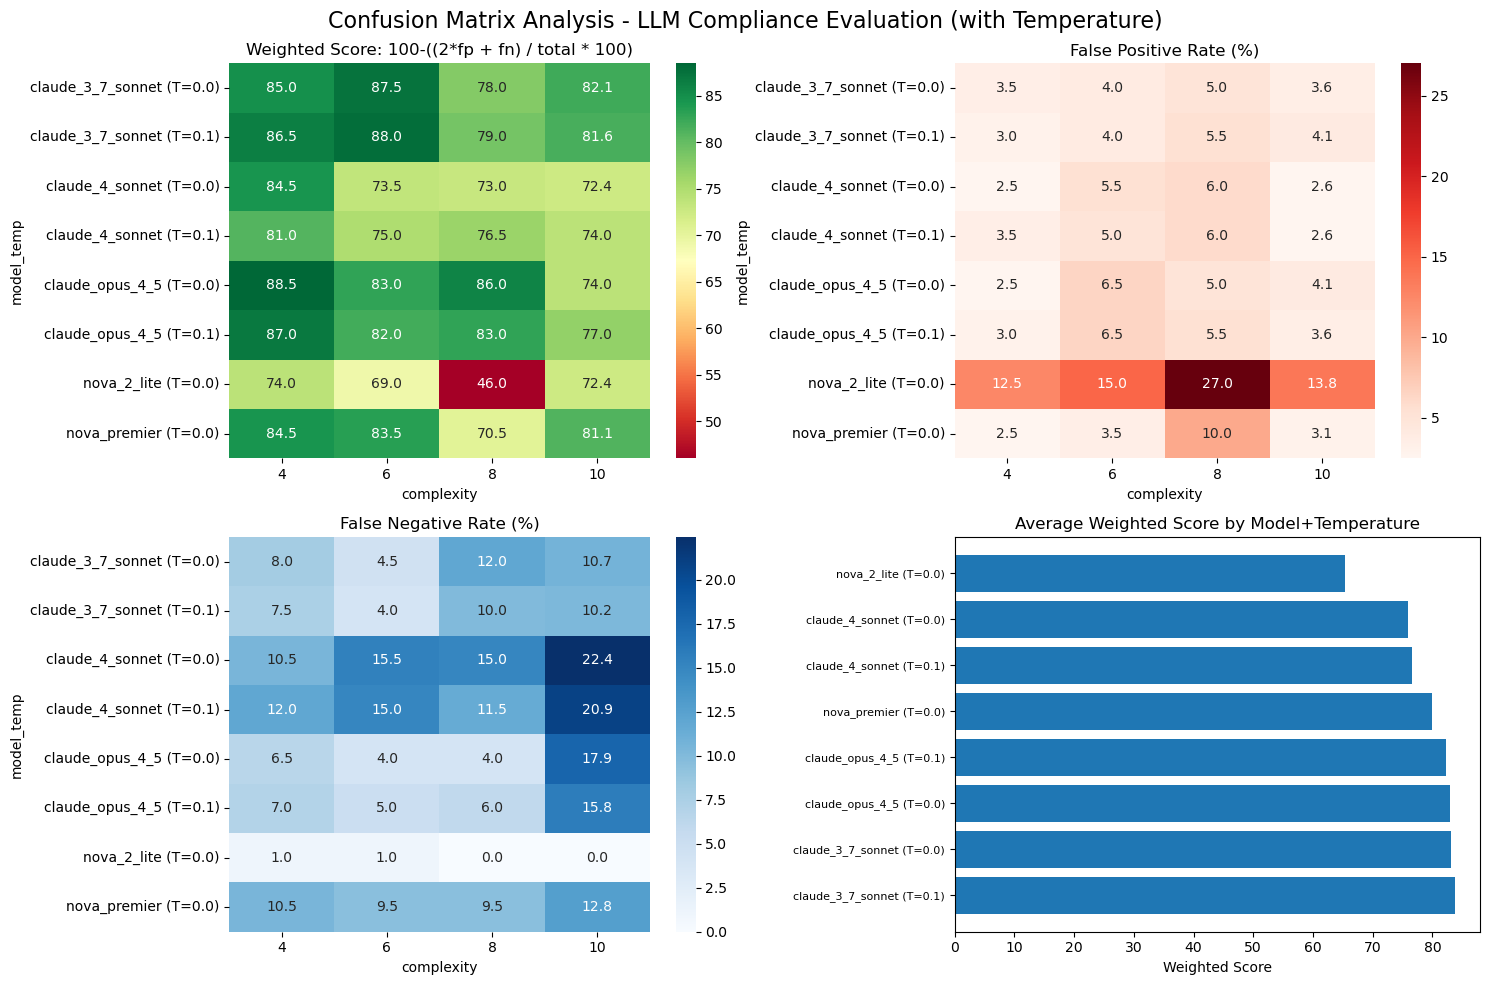


=== WEIGHTED SCORING SUMMARY ===
(False Positives penalized 2x more than False Negatives)
1. claude_3_7_sonnet (T=0.1): 83.8
2. claude_3_7_sonnet (T=0.0): 83.2
3. claude_opus_4_5 (T=0.0): 82.9
4. claude_opus_4_5 (T=0.1): 82.3
5. nova_premier (T=0.0): 79.9
6. claude_4_sonnet (T=0.1): 76.6
7. claude_4_sonnet (T=0.0): 75.9
8. nova_2_lite (T=0.0): 65.4


In [2]:
import pandas as pd
import json
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def extract_model_from_filename(filename):
    name = filename.replace('judged_scenarios_batch-scenarios-', '').replace('.json', '')
    parts = name.split('-')
    policies_idx = next(i for i, part in enumerate(parts) if part == 'policies')
    model_parts = parts[policies_idx+2:-1]
    model_name = '_'.join(model_parts)
    if model_name.startswith('200_'):
        model_name = model_name[4:]
    return model_name

def extract_complexity_from_filename(filename):
    match = re.search(r'scenarios-(\d+)-policies-each', filename)
    return int(match.group(1)) if match else None

def extract_temperature_from_filename(filename):
    match = re.search(r'temp(\d+\.?\d*)', filename)
    return float(match.group(1)) if match else None

def analyze_scenarios_in_json_files(folder_path):
    folder = Path(folder_path)
    results = []
    
    for json_file in folder.glob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                scenarios = data.get('scenarios', [])
            
            model = extract_model_from_filename(json_file.name)
            complexity = extract_complexity_from_filename(json_file.name)
            temperature = extract_temperature_from_filename(json_file.name)
            
            # Confusion matrix counters
            tp = fp = tn = fn = 0
            
            for scenario in scenarios:
                is_compliant = scenario.get('is-compliant')
                judged_compliant = scenario.get('judged-compliant')
                
                if is_compliant and judged_compliant:
                    tp += 1
                elif not is_compliant and judged_compliant:
                    fp += 1
                elif not is_compliant and not judged_compliant:
                    tn += 1
                elif is_compliant and not judged_compliant:
                    fn += 1
            
            # Calculate weighted score (FP penalized 2x more than FN)
            total = len(scenarios)
            weighted_score = 100 - ((2 * fp + fn) / total * 100)
            
            results.append({
                'model': model,
                'temperature': temperature,
                'complexity': complexity,
                'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
                'total': total,
                'fp_rate': fp/total*100,
                'fn_rate': fn/total*100,
                'weighted_score': weighted_score
            })
            
        except Exception as e:
            print(f"Error loading {json_file.name}: {e}")
    
    # Create visualizations
    df = pd.DataFrame(results)
    df['model_temp'] = df['model'] + ' (T=' + df['temperature'].astype(str) + ')'
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Confusion Matrix Analysis - LLM Compliance Evaluation (with Temperature)', fontsize=16)
    
    # 1. Weighted Score Heatmap
    pivot_score = df.pivot(index='model_temp', columns='complexity', values='weighted_score')
    sns.heatmap(pivot_score, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[0,0])
    axes[0,0].set_title('Weighted Score: 100-((2*fp + fn) / total * 100)')
    
    # 2. False Positive Rate
    pivot_fp = df.pivot(index='model_temp', columns='complexity', values='fp_rate')
    sns.heatmap(pivot_fp, annot=True, fmt='.1f', cmap='Reds', ax=axes[0,1])
    axes[0,1].set_title('False Positive Rate (%)')
    
    # 3. False Negative Rate
    pivot_fn = df.pivot(index='model_temp', columns='complexity', values='fn_rate')
    sns.heatmap(pivot_fn, annot=True, fmt='.1f', cmap='Blues', ax=axes[1,0])
    axes[1,0].set_title('False Negative Rate (%)')
    
    # 4. Model+Temperature Performance Ranking
    model_scores = df.groupby('model_temp')['weighted_score'].mean().sort_values(ascending=False)
    axes[1,1].barh(range(len(model_scores)), model_scores.values)
    axes[1,1].set_yticks(range(len(model_scores)))
    axes[1,1].set_yticklabels(model_scores.index, fontsize=8)
    axes[1,1].set_title('Average Weighted Score by Model+Temperature')
    axes[1,1].set_xlabel('Weighted Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n=== WEIGHTED SCORING SUMMARY ===")
    print("(False Positives penalized 2x more than False Negatives)")
    for i, (model_temp, score) in enumerate(model_scores.items(), 1):
        print(f"{i}. {model_temp}: {score:.1f}")

# Run analysis
folder_path = '/home/sagemaker-user/data/judged_scenarios'
analyze_scenarios_in_json_files(folder_path)


In [99]:
def main():

    analyze_scenarios_in_json_files("/home/sagemaker-user/data/judged_scenarios")
    
    
    # for json_file in Path(FOLDER_JUDGED_SCENARIOS).glob("*.json"):
    #     json_to_csv(json_file = json_file, csv_file_path = FOLDER_JUDGED_SCENARIOS_CSV)
    
    # concatenate_csv_files(input_path=FOLDER_JUDGED_SCENARIOS_CSV, output_file_path=FOLDER_JUDGED_SCENARIOS_CSV / "combined_output.csv")

In [100]:
main()



judged_scenarios_batch-scenarios-8-policies-each-claude_3_7_sonnet-temp0.1.json
Model: claude_3_7_sonnet
Temp: 0.1
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        80         20
Non-Compliant    11         89
% False Positive: 5.5%       % False Negative: 10.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_4_sonnet-temp0.0.json
Model: claude_4_sonnet
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        70         30
Non-Compliant    12         88
% False Positive: 6.0%       % False Negative: 15.0%


judged_scenarios_batch-scenarios-8-policies-each-claude_opus_4_5-temp0.0.json
Model: claude_opus_4_5
Temp: 0.0
Scenario Complexity: 8
Total=200
Confusion Matrix:
                Predicted
Actual      Compliant  Non-Compliant
Compliant        92          8
Non-Compliant    10         90
% False Positive: 5.0% 